In [3]:
import pandas as pd
import numpy as np
import subprocess
from sklearn.manifold import TSNE
from Bio.Cluster import kcluster
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

## Prepare for analysis

In [ ]:
input="CD45"
#input_dataframe=pd.read_csv(f"output/{input}/opt_binders/all.csv")
input_dataframe=pd.read_csv(f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/opt_binders/all.csv")
input_dataframe

,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,seq
0,0.670110,0.929130,0.832793,4.527268,1.790629,0.186849,output/CD45/opt_binders/binders/08OM_pd_30_59_...,output/CD45/opt_binders/binders/08OM_pd_30_59_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
1,0.751444,0.919789,0.818944,4.783027,1.878976,0.196903,output/CD45/opt_binders/binders/08OM_pd_30_59_...,output/CD45/opt_binders/binders/08OM_pd_30_59_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
2,0.669590,0.915322,0.813211,5.100975,1.937699,0.214418,output/CD45/opt_binders/binders/08OM_pd_30_59_...,output/CD45/opt_binders/binders/08OM_pd_30_59_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
3,0.691333,0.900773,0.807139,5.168328,1.970250,0.239317,output/CD45/opt_binders/binders/08OM_pd_30_59_...,output/CD45/opt_binders/binders/08OM_pd_30_59_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
4,0.666273,0.927595,0.819401,4.785713,1.891322,0.258927,output/CD45/opt_binders/binders/08OM_pd_30_59_...,output/CD45/opt_binders/binders/08OM_pd_30_59_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
...,...,...,...,...,...,...,...,...,...
18535,1.051235,0.935382,0.879641,6.158912,1.815851,0.683518,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDC...
18536,0.984141,0.936416,0.873833,6.242943,1.816065,0.729682,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDC...
18537,0.969927,0.917304,0.842011,7.011598,2.052752,0.889165,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDC...
18538,0.963087,0.943788,0.891590,5.909364,1.700439,0.991854,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDC...


In [ ]:
# Functions
# add scaffold name column
def add_scaffold_name_column(filtered, prefix):
    filtered["scaffold_name"] = ""
    
    for index, row in filtered.iterrows():
        path = row["model_path"]
        prefix = prefix
        file_name = path.split("/")[-1]
        parts = file_name.split(prefix)[-1].split("_")
        
        if len(parts) >= 5:
            result = f"{parts[0]}_{parts[1]}"
        else:
            result = parts[0].split(".")[0]
        
        filtered.at[index, "scaffold_name"] = result
    
    return filtered

def repeat_rows_by_column_value(df, column_name, number):
    unique_values = df[column_name].unique()
    repeated_rows = []

    for value in unique_values:
        subset = df[df[column_name] == value]
        num_repeats = min(number, subset.shape[0])
        repeated_rows.extend([subset.iloc[i, :] for i in range(num_repeats)])

    repeated_df = pd.DataFrame(repeated_rows)
    return repeated_df

#best_binders=add_scaffold_name_column(best_binders, input+"_")

## Filter dataframe

In [ ]:
#filtered = input_dataframe[(input_dataframe["rmsd"]<1)&(input_dataframe["plddt"]>0.85)&input_dataframe["i_pae"]<6]
filtered =input_dataframe[(input_dataframe["plddt"]>0.90)&(input_dataframe["i_pae"]<6)&(input_dataframe["rmsd"]<1.5)]

filtered = filtered.sort_values(by='plddt', ascending=False).drop_duplicates("model_path").reset_index()#.head(9900)
filtered

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,seq
0,10266,0.775928,0.962946,0.889144,3.371282,1.394882,0.421287,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
1,9929,0.781935,0.956744,0.884477,4.155853,1.515078,0.466654,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
2,10639,0.740926,0.956313,0.880270,3.579909,1.494151,0.355596,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
3,10641,0.698469,0.956208,0.878236,3.586581,1.505213,0.377235,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
4,10653,0.695593,0.954864,0.865711,3.808620,1.606039,0.713898,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
...,...,...,...,...,...,...,...,...,...,...
3010,3989,0.840320,0.900142,0.814573,5.388604,2.022377,0.610586,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
3011,5361,0.929274,0.900138,0.804008,5.962784,2.072586,0.624496,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
3012,17166,0.890557,0.900039,0.796695,5.853870,2.142589,0.634762,output/CD45/opt_binders/binders/HJY2_pd_25_21_...,/home/tsatler/RFdif/ClusterProteinDesign/scrip...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...
3013,3886,0.879700,0.900024,0.835095,5.609940,1.919379,1.006023,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...


In [ ]:
filtered=add_scaffold_name_column(filtered, input+"_")
filtered

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,seq,scaffold_name
0,10266,0.775928,0.962946,0.889144,3.371282,1.394882,0.421287,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
1,9929,0.781935,0.956744,0.884477,4.155853,1.515078,0.466654,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
2,10639,0.740926,0.956313,0.880270,3.579909,1.494151,0.355596,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
3,10641,0.698469,0.956208,0.878236,3.586581,1.505213,0.377235,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
4,10653,0.695593,0.954864,0.865711,3.808620,1.606039,0.713898,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
...,...,...,...,...,...,...,...,...,...,...,...
3010,3989,0.840320,0.900142,0.814573,5.388604,2.022377,0.610586,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
3011,5361,0.929274,0.900138,0.804008,5.962784,2.072586,0.624496,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
3012,17166,0.890557,0.900039,0.796695,5.853870,2.142589,0.634762,output/CD45/opt_binders/binders/HJY2_pd_25_21_...,/home/tsatler/RFdif/ClusterProteinDesign/scrip...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,HJY2_pd
3013,3886,0.879700,0.900024,0.835095,5.609940,1.919379,1.006023,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd


In [ ]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)

Total unique scaffolds: 14
Total scaffold instances: 3015

Scaffold counts:
0XKF_pd    1337
4FSF_pd     374
08OM_pd     339
HJY2_pd     291
1SM1_pd     153
8WPT_pd     140
2T0M_pd      84
739X_pd      74
4D4P_pd      65
L7TM_pd      58
6UJ8_pd      37
06MR_pd      34
AUT3_pd      22
6QOP_pd       7
Name: scaffold_name, dtype: int64


In [ ]:
filtered=repeat_rows_by_column_value(filtered, "scaffold_name", 1)
folder=f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/test"
os.makedirs(folder, exist_ok=True)
for path in filtered["model_path"]:
    !cp $path $folder


In [ ]:
# good_scaffolds = ["2_","55_","61_","54_","24_","13_","11_"]

# # Filter the DataFrame
# #filtered = filtered[filtered['scaffold_name'].isin(good_scaffolds)]
# filtered = filtered[~filtered['scaffold_name'].isin(good_scaffolds)]
# filtered
#for  scaff in good_scaffolds:
#    filtered=filtered[scaff]

# bad_scaffolds = ["model_30","model_42", "model_1-lcb3"]

# Filter the DataFrame
# good = filtered[~filtered['scaffold_name'].isin(bad_scaffolds)]
# good

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,seq,scaffold_name
0,20291,0.680409,0.970570,0.906184,4.084421,1.470782,0.138132,output/cd19/opt_binders/binders/cd19_model_54_...,output/cd19/opt_binders/binders/cd19_model_54_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_54
1,20649,0.681101,0.969551,0.904424,4.144505,1.482504,0.290271,output/cd19/opt_binders/binders/cd19_model_54_...,output/cd19/opt_binders/binders/cd19_model_54_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_54
2,20361,0.683889,0.969122,0.906854,4.110478,1.465106,0.206169,output/cd19/opt_binders/binders/cd19_model_54_...,output/cd19/opt_binders/binders/cd19_model_54_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_54
3,20727,0.753622,0.969093,0.904639,4.137549,1.489811,0.107573,output/cd19/opt_binders/binders/cd19_model_54_...,output/cd19/opt_binders/binders/cd19_model_54_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_54
4,20377,0.653111,0.969017,0.904000,4.165711,1.466138,0.219546,output/cd19/opt_binders/binders/cd19_model_54_...,output/cd19/opt_binders/binders/cd19_model_54_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_54
...,...,...,...,...,...,...,...,...,...,...,...
13258,15613,0.784453,0.920045,0.825058,5.705825,2.100123,0.806935,output/cd19/opt_binders/binders/cd19_model_5_3...,output/cd19/opt_binders/binders/cd19_model_5_3...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_5
13259,10539,0.789086,0.920044,0.862026,5.202763,1.893250,0.649210,output/cd19/opt_binders/binders/cd19_model_27_...,output/cd19/opt_binders/binders/cd19_model_27_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_27
13260,16155,0.747037,0.920042,0.838261,5.103581,1.995168,0.391711,output/cd19/opt_binders/binders/cd19_model_49_...,output/cd19/opt_binders/binders/cd19_model_49_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_49
13261,3638,0.669862,0.920028,0.842768,5.634965,1.985036,0.728073,output/cd19/opt_binders/binders/cd19_model_19_...,output/cd19/opt_binders/binders/cd19_model_19_...,PLVVKVEEGDNAVLQCLTQQLTWSRESPLKPFLKLSLGLPGLGIHV...,model_19


In [ ]:
#filtered=repeat_rows_by_column_value(filtered, "scaffold_name", 200)
filtered

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,seq,scaffold_name
0,10266,0.775928,0.962946,0.889144,3.371282,1.394882,0.421287,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
1,9929,0.781935,0.956744,0.884477,4.155853,1.515078,0.466654,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,output/CD45/opt_binders/binders/0XKF_pd_15_92_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
2,10639,0.740926,0.956313,0.880270,3.579909,1.494151,0.355596,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
3,10641,0.698469,0.956208,0.878236,3.586581,1.505213,0.377235,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
4,10653,0.695593,0.954864,0.865711,3.808620,1.606039,0.713898,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,output/CD45/opt_binders/binders/1SM1_pd_30_19_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,1SM1_pd
...,...,...,...,...,...,...,...,...,...,...,...
3010,3989,0.840320,0.900142,0.814573,5.388604,2.022377,0.610586,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,output/CD45/opt_binders/binders/0XKF_pd_15_38_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
3011,5361,0.929274,0.900138,0.804008,5.962784,2.072586,0.624496,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,output/CD45/opt_binders/binders/0XKF_pd_15_48_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd
3012,17166,0.890557,0.900039,0.796695,5.853870,2.142589,0.634762,output/CD45/opt_binders/binders/HJY2_pd_25_21_...,/home/tsatler/RFdif/ClusterProteinDesign/scrip...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,HJY2_pd
3013,3886,0.879700,0.900024,0.835095,5.609940,1.919379,1.006023,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,output/CD45/opt_binders/binders/0XKF_pd_15_37_...,PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVR...,0XKF_pd


In [ ]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])
#filtered["seq_split"].to_list()

## Testing cluster sequences

In [ ]:
seqs=filtered["seq_split"].to_list()

In [ ]:
def length_statistics(input_list):
    length_stats = {}
    
    for item in input_list:
        item_length = len(item)
        length_stats[item_length] = length_stats.get(item_length, 0) + 1
    
    return length_stats

seqs_len=length_statistics(seqs)
print(seqs_len)

{65: 2752, 63: 157, 64: 106}


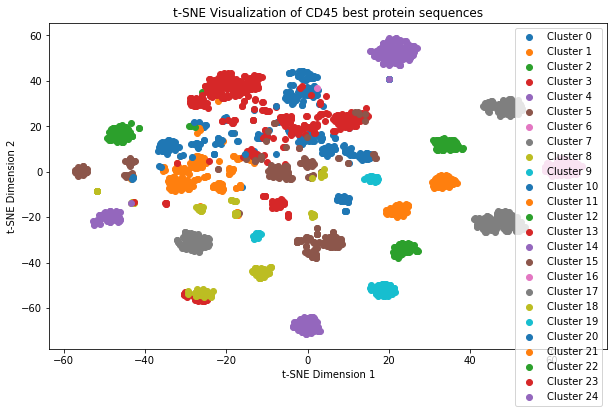

Cluster 0: 313 sequences
Cluster 1: 67 sequences
Cluster 2: 75 sequences
Cluster 3: 32 sequences
Cluster 4: 90 sequences
Cluster 5: 126 sequences
Cluster 6: 110 sequences
Cluster 7: 254 sequences
Cluster 8: 43 sequences
Cluster 9: 73 sequences
Cluster 10: 44 sequences
Cluster 11: 237 sequences
Cluster 12: 86 sequences
Cluster 13: 440 sequences
Cluster 14: 158 sequences
Cluster 15: 203 sequences
Cluster 16: 1 sequences
Cluster 17: 98 sequences
Cluster 18: 132 sequences
Cluster 19: 49 sequences
Cluster 20: 93 sequences
Cluster 21: 74 sequences
Cluster 22: 77 sequences
Cluster 23: 63 sequences
Cluster 24: 77 sequences


,index,score,plddt,i_ptm,i_pae,i_con,rmsd
clusterid,,,,,,,
0,5134.916933,0.849357,0.917234,0.821557,5.455640,1.942308,0.560030
1,10789.268657,0.857587,0.932550,0.823224,4.949682,2.030102,0.500901
2,10450.426667,0.756883,0.928978,0.844971,4.445679,1.766532,0.466923
3,398.468750,0.837016,0.932978,0.807590,5.211609,1.925726,0.440449
4,14276.088889,0.883953,0.918001,0.804478,5.180290,1.964447,0.758892
5,15531.285714,0.986116,0.943496,0.889452,5.897825,1.695159,0.440380
6,487.545455,0.843512,0.934828,0.860778,4.100085,1.661807,0.393323
7,5985.094488,0.725581,0.922556,0.820629,4.959411,1.867778,0.424926
8,321.744186,0.850630,0.930467,0.803484,5.333237,1.956003,0.466186


In [ ]:
num_clusters=25

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()


# Print the number of sequences in each cluster.
cluster_counts = Counter(clusterid)
sorted_cluster_counts = dict(sorted(cluster_counts.items()))
for cluster, count in sorted_cluster_counts.items():
    print(f"Cluster {cluster}: {count} sequences")

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

## Prepare metrics command

In [ ]:
save_path = f"output/{input}/opt_binders/filtered.csv" # Save filtered
metric_path = f"output/{input}/opt_binders/metrics.csv" # Save filtered with metrics

# Make filtered dataframe or append new sequences to the old one
if os.path.exists(save_path):
    print("reading existant dataframe...")
    existing_dataframe = pd.read_csv(save_path)
    filtered_new = filtered[~filtered["model_path"].isin(existing_dataframe["model_path"])]
    print(f"existing dataframe of len: {len(existing_dataframe)}, new filtered: {len(filtered_new)}")
    existing_dataframe = pd.concat([existing_dataframe, filtered_new], ignore_index=True)
    print(f"final length: {len(existing_dataframe)}")
    existing_dataframe = existing_dataframe.sort_values(by='plddt', ascending=False)
    #drop duplicates
    existing_dataframe.to_csv(save_path, index=False)
    existing_dataframe.to_csv(metric_path, index=False)

else:
    filtered.to_csv(save_path, index=False)
    filtered.to_csv(metric_path, index=False)
    existing_dataframe=filtered

In [ ]:
print(save_path)

output/CD45/opt_binders/filtered.csv


In [ ]:
#test_path="/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/binders/test"
#os.makedirs(test_path, exist_ok=True)

#for pdb in filtered["model_path"].head(10):
#    !cp $pdb $test_path

## Prepare input files for analysis script

In [ ]:
save_directory = f"output/{input}/opt_binders/analysis_input"

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

batch_size = 1000

# Split the model_paths into batches
model_paths = existing_dataframe["model_path"]
batches = [model_paths[i:i + batch_size] for i in range(0, len(model_paths), batch_size)]

# Save each batch as a separate TXT file
for i, batch in enumerate(batches):
    save_path = os.path.join(save_directory, "model_paths_" + str(i) + ".txt")
    with open(save_path, "w") as file:
        file.write("\n".join(batch))

## Run analysis script

In [ ]:
input_files=glob.glob(f"{save_directory}/*txt")
array_limit=300//len(input_files)
target_chain="A"
binder_chain="B"
xml_file="helper_scripts/metrics_calc.xml"

commands=[]

for input_file in input_files:
    with open(input_file, "r") as file:
        lines = file.readlines()
    array_number = len(lines)-1

    bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
    script_arguments=f"{input_file} {target_chain} {binder_chain} {metric_path} {xml_file}"

    command = f"sbatch {bash_arguments} helper_scripts/binder_analysis.sh {script_arguments}"
    print(command)
    commands.append(command)

print(f"This will run {len(commands)} array scripts")

sbatch --output=/dev/null --array=0-999%75 helper_scripts/binder_analysis.sh output/CD45/opt_binders/analysis_input/model_paths_2.txt A B output/CD45/opt_binders/metrics.csv helper_scripts/metrics_calc.xml
sbatch --output=/dev/null --array=0-999%75 helper_scripts/binder_analysis.sh output/CD45/opt_binders/analysis_input/model_paths_0.txt A B output/CD45/opt_binders/metrics.csv helper_scripts/metrics_calc.xml
sbatch --output=/dev/null --array=0-14%75 helper_scripts/binder_analysis.sh output/CD45/opt_binders/analysis_input/model_paths_3.txt A B output/CD45/opt_binders/metrics.csv helper_scripts/metrics_calc.xml
sbatch --output=/dev/null --array=0-999%75 helper_scripts/binder_analysis.sh output/CD45/opt_binders/analysis_input/model_paths_1.txt A B output/CD45/opt_binders/metrics.csv helper_scripts/metrics_calc.xml
This will run 4 array scripts


In [ ]:
# Run the array bash script
for command in commands:
    subprocess.run(command, shell=True)

Submitted batch job 384381
Submitted batch job 384382
Submitted batch job 384383
Submitted batch job 384384


In [ ]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
384381_[75-999%75]       amd binder_a  tsatler PD       0:00      1 (JobArrayTaskLimit)
384382_[25-999%75]       amd binder_a  tsatler PD       0:00      1 (None)
  384383_[0-14%75]       amd binder_a  tsatler PD       0:00      1 (None)
 384384_[0-999%75]       amd binder_a  tsatler PD       0:00      1 (None)
          384381_0       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_1       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_2       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_3       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_4       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_5       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_6       amd binder_a  tsatler  R       0:12      1 compute-4-0
          384381_7       amd binder_a  tsa